In [1]:
import numpy as np
import scipy.ndimage
import scipy.stats
import pandas
import healpy as hp

import numba

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Setup

A conda environment with all the packages needed can be created with `conda create --name 2d-align-demo --file spec-file.txt`.

The ROCKSTAR halo catalogs and binned density files used can be downloaded from [this private GDrive link](https://drive.google.com/drive/folders/1ZMfkZXaz-A6jQwjzdNNXT49T9UQRravo?usp=sharing).

# Halo catalog

We use the ROCKSTAR halo catalog from Bolshoi-Planck, for a single snapshot: `a = 0.28850` for `z ~ 2.5`, and `a = 0.45556` for `z ~ 1.2`.

The halo catalogs are paired with the corresponding dark matter binned density for the same snapshot. `TWEB_EIGENVEC_PATH` is where the deformation tensor eigenvectors are cached, so we only have to compute them once (since it's a very time/memory intensive operation).

In [2]:
z2_5 = True

if z2_5:
    HALO_CAT_PATH = 'data/hlist_0.28850.list'
    SIM_DENSITY_PATH = 'data/dens_0094.bin'
    TWEB_EIGENVEC_PATH = 'data/z2.5-tweb-eigenvec.npy'
    FIGURE_PATH = 'figures/z2.5'
else:
    HALO_CAT_PATH = 'data/hlist_0.45556.list'
    SIM_DENSITY_PATH = 'data/dens_0127.bin'
    TWEB_EIGENVEC_PATH = 'data/z1.2-tweb-eigenvec.npy'
    FIGURE_PATH = 'figures/z1.2'

`x/y/z_snap` is the halo's position in Mpc/h, while `ax/ay/az_snap` is the halo's longest-axis vector, which we refer to as its shape interchangeably. It's also in Mpc/h, though we normalize it later so the length doesn't matter.

We also take the angular momenta (spin) vectors of each halo, which are `jx/jy/jz_snap`, which we use later.

For halos with low mass, the low number of particles tends to produce axis-aligned shapes/spins. We pre-emptively make a conservative mass cut to mitigate this issue. In actual analysis, the mass cut we set (as a proxy for magnitude) will be much higher than this anyways.

In [3]:
halo_cat = pandas.read_csv(HALO_CAT_PATH, header=None, comment='#', delim_whitespace=True)
named_cols = {1: 'id', 10: 'mvir_snap', 17: 'x_snap', 18: 'y_snap', 19: 'z_snap', 23: 'jx_snap', 24: 'jy_snap', 25: 'jz_snap', 48: 'ax_snap', 49: 'ay_snap', 50: 'az_snap'}
halo_cat.rename(columns=named_cols, inplace=True)
halo_cat = halo_cat[named_cols.values()]
halo_cat.dropna(inplace=True)
# Only halos with particles above limit. Particle mass is 1.55e8 M_sun.
mask = halo_cat.mvir_snap / 1.55e8 > 10
print(f'% halos above particle limit: {np.sum(mask) / len(mask) * 100:.2f}')
halo_cat = halo_cat.loc[mask]

% halos above particle limit: 89.87


In [4]:
halo_cat.head()

,id,mvir_snap,x_snap,y_snap,z_snap,jx_snap,jy_snap,jz_snap,ax_snap,ay_snap,az_snap
0,682117372,2.174000e+13,35.58041,42.79334,19.29873,9.041000e+13,-1.041000e+14,1.441000e+13,13.28160,63.98390,21.80350
1,682117373,2.103000e+13,35.71436,43.10278,19.58245,6.771000e+13,-1.314000e+14,1.050000e+13,48.49790,119.58800,123.44000
2,682117374,1.720000e+10,35.58666,42.74437,19.37591,3.176000e+08,-1.095000e+09,1.278000e+09,7.11186,1.13578,5.01779
3,682117376,7.438000e+09,35.48992,42.88188,19.29111,4.016000e+08,-4.535000e+08,-1.448000e+08,6.15048,3.70290,0.91555
4,682117377,6.509000e+09,35.41239,42.67072,19.20074,4.176000e+08,-1.061000e+08,-4.371000e+08,4.95206,5.20717,-2.24966


In [5]:
halo_positions = halo_cat[['x_snap', 'y_snap', 'z_snap']].to_numpy()
halo_shapes = halo_cat[['ax_snap', 'ay_snap', 'az_snap']].to_numpy()

# Cosmic web deformation tensor

We compute the deformation tensor eigenvectors from the binned DM density and save them.

We smooth the density before computing the deformation tensor, so the tensor doesn't vary wildly from point to point. We follow Krolewski et al. 2016, and smooth with a constant 2 Mpc/h Gaussian kernel. Due to memory constraints, we also rebin the density down from 1024 pixels to 512 pixels, via sum.

As a reminder, the eigenvectors of the deformation tensor are $\vec{e_1}, \vec{e_2}, \vec{e_3}$, which are sorted in descending order by their corresponding eigenvalues.
The direction of cosmic web filaments is along $\vec{e_3}$, as is the plane of cosmic web sheets.

The output of `compute_deformation_tensor()` is a `512 x 512 x 512 x 3 x 3` ndarray. The `3 x 3` matrix at each point is the deformation tensor eigenvectors, but slicing along the 1st, not the 0th axis, of the matrix yields the tensor eigenvectors.

In [6]:
# Credit to Alex Krolewski.
def compute_deformation_tensor(dm_density):
	delta_k = np.fft.fftn(dm_density)
	kx = np.fft.fftfreq(len(delta_k))
	ky = np.fft.fftfreq(len(delta_k))
	kz = np.fft.fftfreq(len(delta_k))
	kx_3d,ky_3d,kz_3d = np.meshgrid(kx,ky,kz)
	ksq_3d = kx_3d**2 + ky_3d**2 + kz_3d**2

	t_kxkx = kx_3d*kx_3d*delta_k/ksq_3d
	t_kxky = kx_3d*ky_3d*delta_k/ksq_3d
	t_kxkz = kx_3d*kz_3d*delta_k/ksq_3d
	t_kyky = ky_3d*ky_3d*delta_k/ksq_3d
	t_kykz = ky_3d*kz_3d*delta_k/ksq_3d
	t_kzkz = kz_3d*kz_3d*delta_k/ksq_3d

	t_kxkx[0,0,0] = 0
	t_kxky[0,0,0] = 0
	t_kxkz[0,0,0] = 0
	t_kyky[0,0,0] = 0
	t_kykz[0,0,0] = 0
	t_kzkz[0,0,0] = 0

	t_xx = np.fft.ifftn(t_kxkx)
	t_xy = np.fft.ifftn(t_kxky)
	t_xz = np.fft.ifftn(t_kxkz)
	t_yy = np.fft.ifftn(t_kyky)
	t_yz = np.fft.ifftn(t_kykz)
	t_zz = np.fft.ifftn(t_kzkz)

	t_xx = np.real(t_xx)
	t_xy = np.real(t_xy)
	t_xz = np.real(t_xz)
	t_yy = np.real(t_yy)
	t_yz = np.real(t_yz)
	t_zz = np.real(t_zz)

	t_ij = np.array([[t_xx,t_xy,t_xz],[t_xy,t_yy,t_yz],[t_xz,t_yz,t_zz]])
	t_ij_trans = np.transpose(t_ij,axes=(2,3,4,0,1))

	e = np.linalg.eigh(t_ij_trans)
	return e

In [7]:
def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.

    Number of output dimensions must match number of input dimensions and 
        new axes must divide old ones.

    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)

    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]

    """
    operation = operation.lower()
    if not operation in ['sum', 'mean']:
        raise ValueError("Operation not supported.")
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                  ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        op = getattr(ndarray, operation)
        ndarray = op(-1*(i+1))
    return ndarray


**Warning: if computing the deformation tensor from scratch, the notebook takes >60 GB of memory; when loading a cached deformation tensor, the notebook takes ~20 GB in total.**

In [8]:
SIM_MPC_LEN = 250
TWEB_SMOOTHING_SCALE_MPC = 2

try:
    tweb_eigenvec = np.load(TWEB_EIGENVEC_PATH)
except FileNotFoundError:
    dm_density = np.fromfile(SIM_DENSITY_PATH, '<f4').astype(np.float64)
    dm_density = np.reshape(dm_density, (1024,1024,1024), order='F')
    # Rebin density.
    dm_density = bin_ndarray(dm_density, (512, 512, 512))
    mpc_per_pix = SIM_MPC_LEN / dm_density.shape[0]
    # Gaussian smooth.
    dm_density = scipy.ndimage.gaussian_filter(dm_density, TWEB_SMOOTHING_SCALE_MPC / mpc_per_pix)
    tweb_eigenvec = compute_deformation_tensor(dm_density)[1]
    np.save(TWEB_EIGENVEC_PATH, tweb_eigenvec)

In [9]:
tweb_npix = tweb_eigenvec.shape[0]

# 3D Alignment

For each halo, we pick out the nearest grid point's eigenvector and compute the absolute value of the halo's longest-axis/shape vector, $\vec{s}$ and the eigenvector.

We take the absolute value since the longest-axis vector and its negative describe the same thing.

According to tidal alignment theory, halo shapes preferentially align with filaments and along sheets, which $\vec{e_3}$ points along in both cases. When looking at the distribution of dot products, we expect to see, and do see, a bias towards 1. Lots of other studies have shown this for simulated halos at $z \sim 0$ (see [here](https://ui.adsabs.harvard.edu/abs/2014MNRAS.443.1090F/abstract) or [here](https://ui.adsabs.harvard.edu/abs/2013MNRAS.428.2489L/abstract)).

In [10]:
# eigenvec_index = 0/1/2 for e_3/e_2/e_1.
@numba.njit
def nearest_eigenvecs(positions, eigenvec_index):
    tweb = tweb_eigenvec[:, :, :, :, eigenvec_index]
    nearest_eigenvecs = np.zeros_like(positions)
    for i, pos_mpc in enumerate(positions):
        pos_pix = pos_mpc * tweb_npix / SIM_MPC_LEN
        # Hack since numba's implementation of np.round doesn't work.
        pos_pix = np.array([round(pos_pix[0]), round(pos_pix[1]), round(pos_pix[2])])
        rounded_pix = np.minimum(pos_pix, tweb_npix - 1)
        nearest_eigenvecs[i] = tweb[rounded_pix[0], rounded_pix[1], rounded_pix[2], :]
    return nearest_eigenvecs

In [11]:
halo_e3 = nearest_eigenvecs(halo_positions, 0)

In [12]:
assert np.sum(np.isfinite(halo_e3)) == len(halo_e3.flatten())
assert np.sum(np.isfinite(halo_shapes)) == len(halo_shapes.flatten())

In [13]:
@numba.njit
def dot_product(eigenvecs, shapes):
    norm_eigenvecs = eigenvecs / np.sqrt(eigenvecs[:, 0]**2 + eigenvecs[:, 1]**2 + eigenvecs[:, 2]**2).reshape(-1, 1)
    norm_shapes = shapes / np.sqrt(shapes[:, 0]**2 + shapes[:, 1]**2 + shapes[:, 2]**2).reshape(-1, 1)
    dot = np.array([np.dot(norm_eigenvecs[i], norm_shapes[i]) for i in range(len(norm_eigenvecs))])
    return np.abs(dot)

In [14]:
e3_align = dot_product(halo_e3, halo_shapes)
# Some of the shape vectors are all zeros, which leads to nan.
print(f'{np.sum(np.isnan(e3_align))} dot products are NaN, out of {len(e3_align)}.')
e3_align = e3_align[~np.isnan(e3_align)]

<ipython-input-13-17bd9cec8cbb>:5: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  dot = np.array([np.dot(norm_eigenvecs[i], norm_shapes[i]) for i in range(len(norm_eigenvecs))])


0 dot products are NaN, out of 16600412.


In [15]:
print(f'Sanity check: dot product min/max is {np.min(e3_align)}, {np.max(e3_align)}')

Sanity check: dot product min/max is 7.183567304891447e-08, 0.9999999975185403


To make the trend clearer, we plot the dot product as a density histogram of 5 bins. The horizontal line at `y = 1` is the null case of no alignment trend.

We also calculate the chi-squared metric and p-value for the (non-density) histogram bins.

Chi-squared = 6.66e+03 | P-value = 0.0


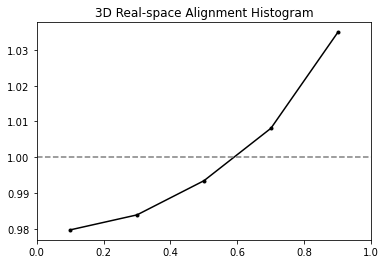

In [16]:
num, edges = np.histogram(e3_align, bins=5, density=True)
centers = 0.5 * (edges[1:] + edges[:-1])

plt.plot(centers, num, 'k.-')
plt.xlim(0, 1)
plt.axhline(1, linestyle='--', color='grey')
plt.title('3D Real-space Alignment Histogram')

chi_sq, chi_sq_pval = scipy.stats.chisquare(np.histogram(e3_align, bins=5)[0])
print(f'Chi-squared = {chi_sq:.3} | P-value = {chi_sq_pval:.3}')

plt.savefig(f'{FIGURE_PATH}/00-3d-align.png')

# 2D Alignment

Since in practice we can't measure the true 3D extent of galaxies, and can only measure their projections onto the sky, we want to see if an alignment trend in 3D space translates to one we can measure on the sky, which we call the 2D alignment.

To do this, we vector-project all halo shape vectors **and** $\vec{e_3}$ onto the plane normal to a chosen line-of-sight vector. We then repeat the dot product calculation.

The null distribution of dot products we compare to is more complicated than in the 3D case--instead of being flat, it takes the form of $2Beta(0.5, 0.5) - 1$ where $Beta$ is the beta distribution with parameters $\alpha = \beta = 1/2$. This is because we can model no 3D alignment trend as pairs of uncorrelated random-direction vectors. (Derived [here](https://stats.stackexchange.com/questions/85916/distribution-of-scalar-products-of-two-random-unit-vectors-in-d-dimensions)).

Since we only care about the absolute value of the dot products, we multiply the PDF of the null distribution by 2, and only look at the PDF between 0 and 1.

The null distribution has a mean angle of $\frac{\pi}{4}$ between the two vectors, so we also compute Krolewski's summary statistic for how strong the 2D alignment trend is: $\overline{arccos(\vec{s} \bullet \vec{e_3})} - \frac{\pi}{4}$. The more negative this summary statistic is, the stronger the 2D alignment trend is.

Because of the cosmological principle, we expect the 2D alignment trend for all halos in the snapshot to be **about the same regardless of the line-of-sight chosen**; if we randomly choose a bunch of lines of sight in random directions, the 2D alignment along them should be vaguely normally distributed.

**For the Bolshoi-Planck snapshot, we're not seeing this.** Instead, for a single preferred direction, we see an absurdly strong 2D alignment, and almost no trend in all other directions.

In [17]:
@numba.njit
def project_onto_plane(vecs, plane_norm_vec):
    projected_vecs = np.zeros_like(vecs)
    for i, v in enumerate(vecs):
        v_norm = np.dot(v, plane_norm_vec) / np.dot(plane_norm_vec, plane_norm_vec) * plane_norm_vec
        v_perp = v - v_norm
        projected_vecs[i] = v_perp
    return projected_vecs

To take a closer look, we plot the mean-angle statistic for an evenly-spaced grid of lines-of-sight on a sphere.

Number of HEALPix: 768


<ipython-input-17-0c19368635fd>:5: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  v_norm = np.dot(v, plane_norm_vec) / np.dot(plane_norm_vec, plane_norm_vec) * plane_norm_vec
/global/homes/b/bzh/.conda/envs/2d-align-demo/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
  newcm.set_over(newcm(1.0))
/global/homes/b/bzh/.conda/envs/2d-align-demo/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the color

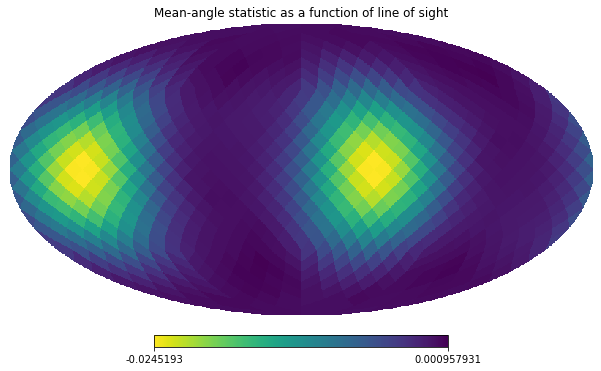

In [18]:
np.random.seed(42)
MAP_NSIDE = 8
SUBSAMPLE_SIZE = 1000000

align_map_pix = np.zeros(hp.nside2npix(MAP_NSIDE))
align_map_min = (np.inf, None)
align_map_max = (-np.inf, None)

print(f'Number of HEALPix: {len(align_map_pix)}')

# Since we have to project onto so many lines of sight, take a smaller sample of the halos.
sample_ind = np.arange(0, len(halo_e3))
np.random.shuffle(sample_ind)
sample_ind = sample_ind[:SUBSAMPLE_SIZE]

sampled_halo_e3 = halo_e3[sample_ind]
sampled_halo_shapes = halo_shapes[sample_ind]

for i in range(len(align_map_pix)):
    los = np.array(hp.pix2vec(MAP_NSIDE, i))
    los /= np.linalg.norm(los)

    proj_e3 = project_onto_plane(sampled_halo_e3.copy(), los)
    proj_shapes = project_onto_plane(sampled_halo_shapes.copy(), los)
    proj_dot = dot_product(proj_e3, proj_shapes)
    proj_dot = proj_dot[~np.isnan(proj_dot)]
    
    mas = np.arccos(proj_dot).mean() - np.pi/4
    
    align_map_pix[i] = mas
    if mas < align_map_min[0]:
        align_map_min = (mas, proj_dot)
    if mas > align_map_max[0]:
        align_map_max = (mas, proj_dot)

hp.mollview(align_map_pix, cmap='viridis_r', title='Mean-angle statistic as a function of line of sight')

plt.savefig(f'{FIGURE_PATH}/01-meanangle-fullsky.png')

In [19]:
print(f'Most negative mean-angle statistic is when LOS is ~{hp.pixelfunc.pix2vec(MAP_NSIDE, np.argmin(align_map_pix))}')

Most negative mean-angle statistic is when LOS is ~(0.70464727188699, -0.7046472718869903, 0.08333333333333333)


We take each cell in the above map and plot its MAS in a histogram.

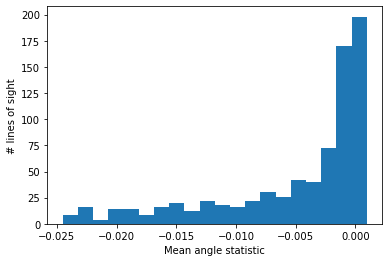

In [20]:
plt.hist(align_map_pix, bins=20)
plt.xlabel('Mean angle statistic')
plt.ylabel('# lines of sight')
plt.savefig(f'{FIGURE_PATH}/02-meanangle-fullsky-hist.png')

In [21]:
def plot_2d_alignment(dot_products, n_bins=5):
    # s is the size of the sample to draw.
    null_dist = lambda s: np.abs(scipy.stats.beta.rvs(0.5, 0.5, loc=-1, scale=2, size=s))
    null_cdf = lambda x: 2 * (scipy.stats.beta.cdf(x, 0.5, 0.5, loc=-1, scale=2) - scipy.stats.beta.cdf(0, 0.5, 0.5, loc=-1, scale=2))
    
    num, edges = np.histogram(dot_products, bins=n_bins, density=True)
    centers = 0.5 * (edges[1:] + edges[:-1])
    
    # Subtract out null distribution's expected density for each bin.
    null_num = np.array([null_cdf(edges[i + 1]) - null_cdf(edges[i]) for i in range(len(num))]) * n_bins
    num -= null_num
    
    plt.plot(centers, num, 'k.-')
    plt.xlim(0, 1)
    plt.axhline(0, linestyle='--', color='grey')

    # Compute chi-squared against non-uniform null distribution.
    chi_sq, chi_sq_pval = scipy.stats.chisquare(np.histogram(dot_products, bins=n_bins)[0], f_exp=null_num / n_bins * len(dot_products))
    plt.title(f'Chi-squared = {chi_sq:.3} | P-value = {chi_sq_pval:.3} | Mean-angle statistic = {np.nanmean(np.arccos(dot_products)) - np.pi/4:.3}')

To make sure that a very negative MAS corresponds to a strong positive alignment trend and v.v for a positive/near-zero MAS, we plot the most negative and most positive MASs from the grid above.

Most negative mean-angle statistic: strongest 2D alignment trend.


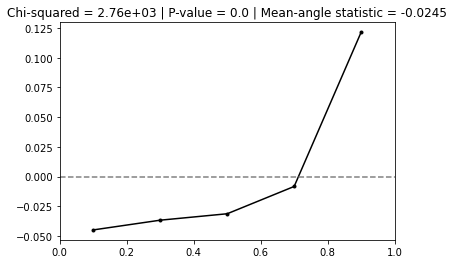

Most positive mean-angle statistic: weakest 2D alignment trend.


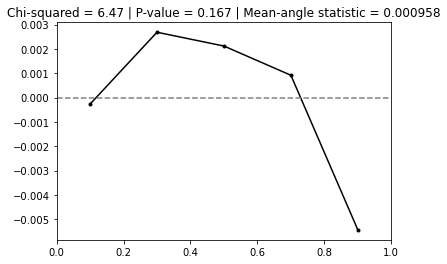

In [22]:
# Plot most negative and least negative mean-angles' 2D alignment histograms.
print('Most negative mean-angle statistic: strongest 2D alignment trend.')
plot_2d_alignment(align_map_min[1])
plt.savefig(f'{FIGURE_PATH}/03-strongest-2d-align.png')

plt.show()

plt.cla()

print('Most positive mean-angle statistic: weakest 2D alignment trend.')
plot_2d_alignment(align_map_max[1])
plt.savefig(f'{FIGURE_PATH}/04-weakest-2d-align.png')
plt.show()

## Things we ruled out for possible causes

### 1. The halo shape vectors are anisotropic, while eigenvectors are isotropic

We bin the halo shape vectors into a histogram, using HEALPix as the bins, and plot:

In [23]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, el

def shape_to_ang(ax, ay, az, reflect_shapes):
    phi_list, theta_list = cart2sph(ax, ay, az)
    # Normalize phi to be between 0 and 2pi, and theta to be between -pi/2 and pi/2.
    phi_list += np.pi
    theta_list -= np.pi / 2
    theta_list *= -1

    # Multiply all vectors on the lower half of the unit sphere (theta > pi/2) by -1.
    if reflect_shapes:
        reflected = theta_list > np.pi / 2
        phi_list[reflected] += np.pi
        phi_list %= 2 * np.pi

        theta_list[reflected] = np.pi - theta_list[reflected]
        assert (theta_list[reflected] >= 0).all() and (theta_list[reflected] <= np.pi).all()
    
    return phi_list, theta_list

# Source: https://stackoverflow.com/questions/50483279/make-a-2d-histogram-with-healpix-pixellization-using-healpy
def cat2hpx(theta, phi, nside):
    """
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates

    """

    npix = hp.nside2npix(nside)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map

def vector_hist_plot(vecs, reflect_shapes, nside=MAP_NSIDE, cmap='RdBu', vmin=None, vmax=None):
    phi, theta = shape_to_ang(vecs[:, 0], vecs[:, 1], vecs[:, 2], reflect_shapes) 
    hpx_map = cat2hpx(theta, phi, nside)
    
    hp.mollview(hpx_map, cmap=cmap, cbar=None, min=vmin, max=vmax)
    scm = mpl.cm.ScalarMappable(cmap=cmap)
    scm.set_clim(vmin=vmin, vmax=vmax)
    scm.set_array(hpx_map)
    clrbar = plt.colorbar(scm, label='# halos in pixel')
    return hpx_map

/global/homes/b/bzh/.conda/envs/2d-align-demo/lib/python3.7/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


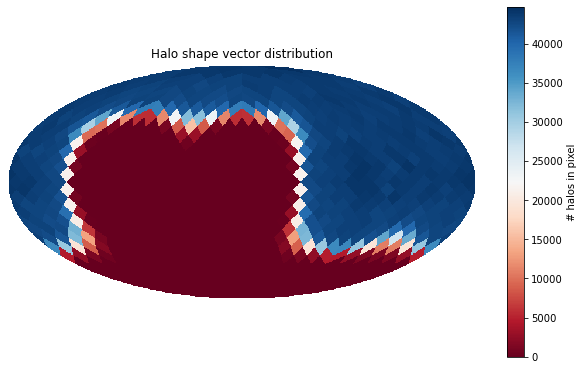

In [24]:
vector_hist_plot(halo_shapes, False, nside=8)
plt.title('Halo shape vector distribution')
plt.savefig(f'{FIGURE_PATH}/05-shape-fullsky-noreflect.png')

While this looks horribly anisotropic, since it makes no difference for alignment whether we use a halo shape vector or its negative, we multiply shape vectors pointing at the lower half of the sphere by -1 and check again:

Text(0.5, 1.0, 'Halo shape vector distribution (lower half reflected onto upper half)')

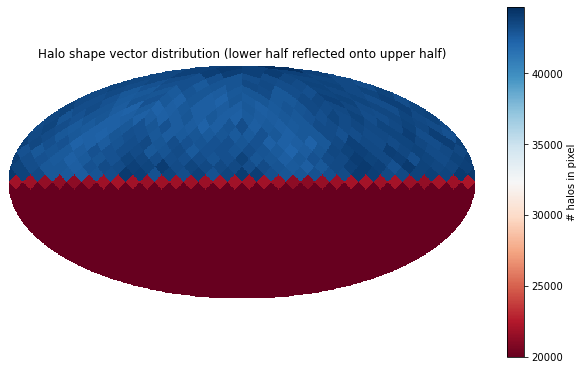

In [25]:
vector_hist_plot(halo_shapes, True, nside=8, vmin=2e4)
plt.title('Halo shape vector distribution (lower half reflected onto upper half)')

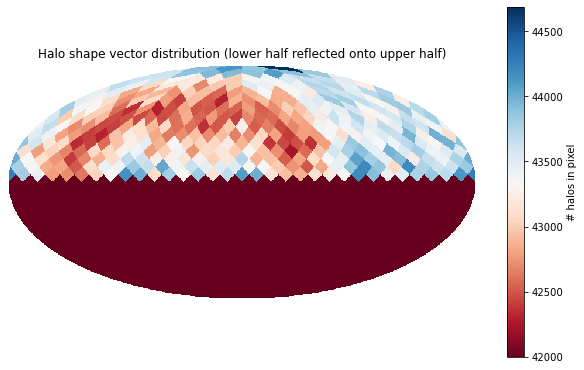

In [35]:
vector_hist_plot(halo_shapes, True, nside=8, vmin=4.2e4)
plt.title('Halo shape vector distribution (lower half reflected onto upper half)')
plt.savefig(f'{FIGURE_PATH}/06-shape-fullsky-reflect.png')

### 2. The nearest $e_3$ eigenvector to each halo is anisotropic, while shape vectors are isotropic

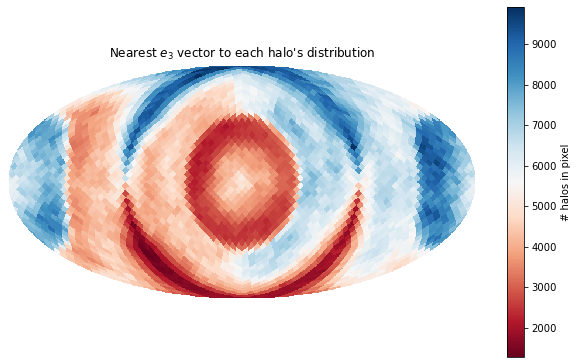

In [27]:
vector_hist_plot(halo_e3, False, nside=16)
plt.title('Nearest $e_3$ vector to each halo\'s distribution')
plt.savefig(f'{FIGURE_PATH}/07-nearest-e3-fullsky-noreflect.png')

Again, this appears highly anisotropic; we're not sure what exactly in the deformation tensor code causes this. It's also present when we take the histogram of every eigenvector in the volume (not just the nearest ones to each halo, which could have repeats):

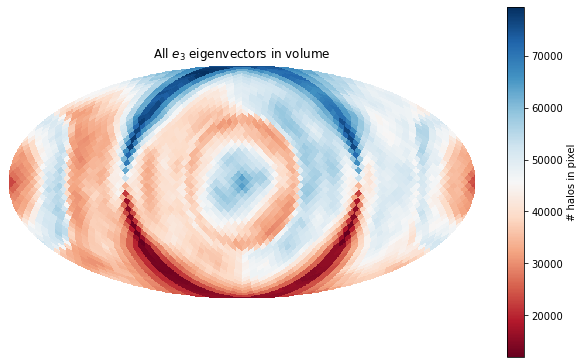

In [28]:
vector_hist_plot(tweb_eigenvec[:, :, :, :, 0].reshape(-1, 3), False, nside=16)
plt.title('All $e_3$ eigenvectors in volume')
plt.savefig(f'{FIGURE_PATH}/08-all-e3-fullsky-reflect.png')

However, since $|a \cdot b| = |(-a) \cdot b| = |a \cdot (-b)| = |(-a) \cdot (-b)|$, we again want to see if after reflecting vectors on the lower half of the unit sphere to the upper half, the resulting histogram appears anisotropic:

Text(0.5, 1.0, "Nearest $e_3$ vector to each halo's distribution (lower half reflected onto upper half)")

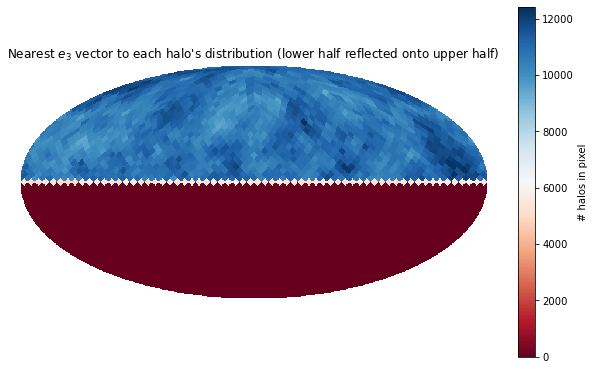

In [29]:
vector_hist_plot(halo_e3, True, nside=16)
plt.title('Nearest $e_3$ vector to each halo\'s distribution (lower half reflected onto upper half)')

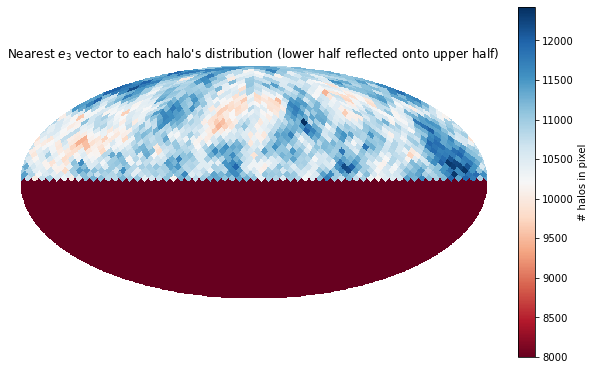

In [30]:
vector_hist_plot(halo_e3, True, nside=16, vmin=8e3)
plt.title('Nearest $e_3$ vector to each halo\'s distribution (lower half reflected onto upper half)')
plt.savefig(f'{FIGURE_PATH}/09-nearest-e3-fullsky-reflect.png')

While the distribution isn't perfectly uniform, there doesn't appear to be a hugely significant anisotropy that lines up with the one we see in the mean-angle statistic.

To double-check that we've been making the right mathematical assumptions about the absolute values of dot products in 3D and 2D, if we do this reflection for both the shapes and the $e_3$ eigenvector, we ought to end up with exactly the same plot of mean-angle statistic as a function of line-of-sight:

Number of HEALPix: 768


/global/homes/b/bzh/.conda/envs/2d-align-demo/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
  newcm.set_over(newcm(1.0))
/global/homes/b/bzh/.conda/envs/2d-align-demo/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
  newcm.set_under(bgcolor)
/global/homes/b/bzh/.conda/envs/2d-align-demo/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globall

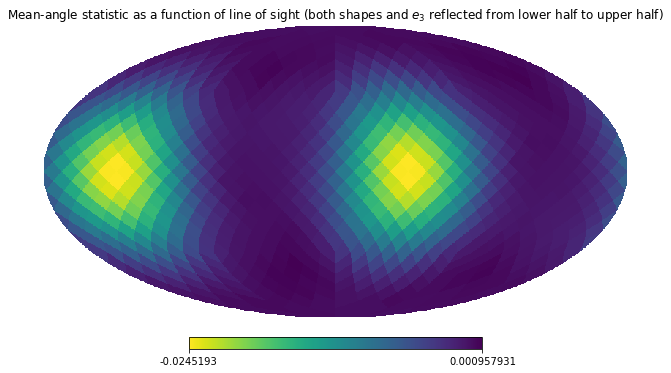

In [31]:
reflected_align_map_pix = np.zeros(hp.nside2npix(MAP_NSIDE))
print(f'Number of HEALPix: {len(align_map_pix)}')

for i in range(len(align_map_pix)):
    los = np.array(hp.pix2vec(MAP_NSIDE, i))
    los /= np.linalg.norm(los)
    
    reflected_halo_e3 = sampled_halo_e3.copy()
    # z < 0 -> on lower half of sphere.
    reflected_halo_e3[reflected_halo_e3[:, 2] < 0] *= -1
    
    reflected_halo_shapes = sampled_halo_shapes.copy()
    reflected_halo_shapes[reflected_halo_shapes[:, 2] < 0] *= -1

    proj_e3 = project_onto_plane(reflected_halo_e3, los)
    proj_shapes = project_onto_plane(reflected_halo_shapes, los)
    proj_dot = dot_product(proj_e3, proj_shapes)
    proj_dot = proj_dot[~np.isnan(proj_dot)]
    
    reflected_align_map_pix[i] = (np.arccos(proj_dot).mean() - np.pi/4)

hp.mollview(reflected_align_map_pix, cmap='viridis_r', title='Mean-angle statistic as a function of line of sight (both shapes and $e_3$ reflected from lower half to upper half)')

plt.savefig(f'{FIGURE_PATH}/10-meanangle-fullsky-reflect.png')

# 2D alignment with spins

Using halo angular momentum vectors instead of shape vectors, we plot MAS across the entire sky again.

In [32]:
halo_spins = halo_cat[['jx_snap', 'jy_snap', 'jz_snap']].to_numpy()

Number of HEALPix: 768


/global/homes/b/bzh/.conda/envs/2d-align-demo/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in arccos


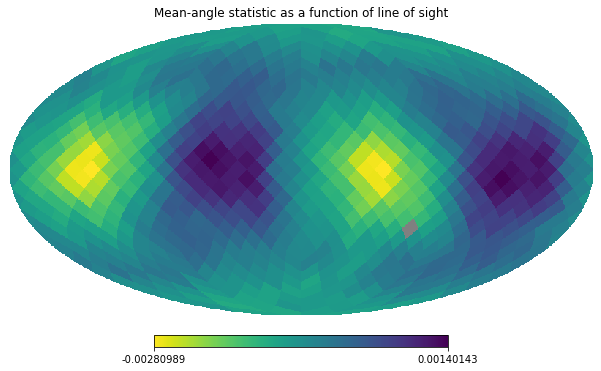

In [33]:
np.random.seed(42)
MAP_NSIDE = 8
SUBSAMPLE_SIZE = 1000000

align_map_pix = np.zeros(hp.nside2npix(MAP_NSIDE))
align_map_min = (np.inf, None)
align_map_max = (-np.inf, None)

print(f'Number of HEALPix: {len(align_map_pix)}')

# Since we have to project onto so many lines of sight, take a smaller sample of the halos.
sample_ind = np.arange(0, len(halo_e3))
np.random.shuffle(sample_ind)
sample_ind = sample_ind[:SUBSAMPLE_SIZE]

sampled_halo_e3 = halo_e3[sample_ind]
sampled_halo_spins = halo_spins[sample_ind]

for i in range(len(align_map_pix)):
    los = np.array(hp.pix2vec(MAP_NSIDE, i))
    los /= np.linalg.norm(los)

    proj_e3 = project_onto_plane(sampled_halo_e3.copy(), los)
    proj_spins = project_onto_plane(sampled_halo_spins.copy(), los)
    proj_dot = dot_product(proj_e3, proj_spins)
    proj_dot = proj_dot[~np.isnan(proj_dot)]
    
    mas = np.arccos(proj_dot).mean() - np.pi/4
    
    align_map_pix[i] = mas
    if mas < align_map_min[0]:
        align_map_min = (mas, proj_dot)
    if mas > align_map_max[0]:
        align_map_max = (mas, proj_dot)

hp.mollview(align_map_pix, cmap='viridis_r', title='Mean-angle statistic as a function of line of sight')

plt.savefig(f'{FIGURE_PATH}/11-halo-spin-meanangle-fullsky.png')

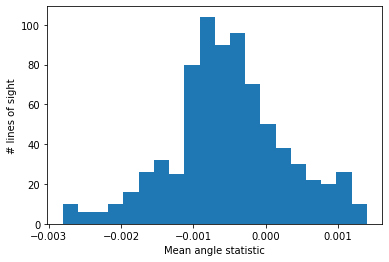

In [34]:
plt.hist(align_map_pix, bins=20)
plt.xlabel('Mean angle statistic')
plt.ylabel('# lines of sight')
plt.savefig(f'{FIGURE_PATH}/12-halo-spin-meanangle-fullsky-hist.png')

MAS exhibits anisotropy in the same spots as halo shapes, but with less (relative) variance. The histogram of every cell also appears better-behaved, with MAS distributed normally around a negative mean.